# Using Word2Vec Embedding to extend Unsupervised Intecepter POC

Let's try applying our intercepter POC with our tried and true guesser heuristics

In [1]:
import decryptoai.word2vec_loader.loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(limit=limit, debug=True)

Loading 200000 keys


In [2]:
# pre-normalize all the vectors
google_news_wv.unit_normalize_all()

Check out the datamuse synthetic dataset notebook if you haven't already. Let's use our associated word JSON to see how well our Intercepter converges on a keyword given associated clues.

In [3]:
import decryptoai.synthetic_dataset.synthetic_datamuse as sd
import decryptoai.config as cfg
import json

with open(str(cfg.MEANING_JSON_PATH)) as f:
    meaning_json_object = json.load(f)

with open(str(cfg.TRIGGERWORD_JSON_PATH)) as f:
    triggerword_json_object = json.load(f)


def legal(keyword, word):
    no_inclusion = (keyword not in word) and (word not in keyword)
    no_british = word not in ["armour", "moustache", "theatre", "mustache", "armor", "theater"]
    return no_inclusion and no_british and word in google_news_wv 

meaning_dataset = sd.filter_illegal_cluewords(legal, meaning_json_object)
triggerword_dataset = sd.filter_illegal_cluewords(legal, triggerword_json_object)


('winter', 'path', 'festival', 'poison')
200000
ok
plotted
1


TypeError: unhashable type: 'numpy.ndarray'

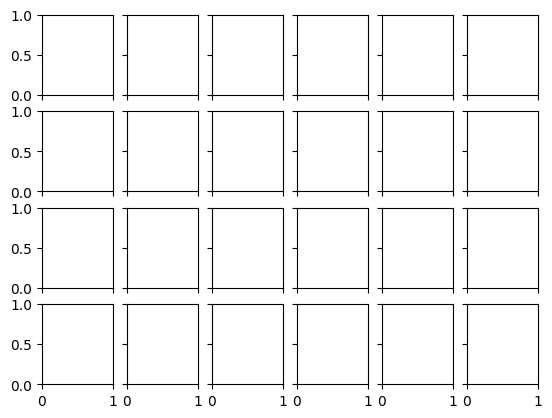

In [4]:
import decryptoai.players.unsupervised.naive_heuristics as heuristics
import decryptoai.players.unsupervised.numpy_guesser as nguesser
import decryptoai.players.unsupervised.numpy_intercepter as nintercepter
from decryptoai.analysis.plot_tools import plot_random_vars
import matplotlib.pyplot as plt
import decryptogame as dg
import numpy as np
from functools import partial


[hidden_kw_card] = next(dg.generators.RandomKeywordCards(card_lengths=[4], seed=200))
code_generator = dg.generators.RandomCodes([hidden_kw_card], seed=200)
hidden_wv_kw_card = tuple(wv_loader.official_keyword_to_word(keyword) for keyword in hidden_kw_card)
print(hidden_wv_kw_card)

num_rounds = 5
clue_and_keyword_to_log_prob_func = partial(heuristics.log_normalized_cosine_similarity, google_news_wv)

_, axs = plt.subplots(4, num_rounds + 1, sharex=True, sharey=True)
random_vars = nintercepter.intercepter_random_variables(google_news_wv.key_to_index, nintercepter.equal_initial_distribution)
reduced_random_vars = nguesser.random_vars_at_least_cumulative_probability(random_vars, 0.1)
print(len(random_vars[0].log_probabilities))
print("ok")
codes = []
guesses = []
#plot_random_vars(random_vars, axs)
print("plotted")
for round in range(1, num_rounds + 1):
    print(round)
    [code] = next(code_generator)
    codes.append(code)
    codewords = (hidden_wv_kw_card[i] for i in code)
    clue = nguesser.np_clues(sd.clue_from_codewords(meaning_dataset, codewords), google_news_wv.key_to_index)
    log_probs = nguesser.log_expected_probabilities_codes(clue_and_keyword_to_log_prob_func, reduced_random_vars, clue)
    guess = sd.all_possible_codes()[np.argmax(log_probs)]
    guesses.append(guess)
    reduced_random_vars = nintercepter.updated_random_vars(clue_and_keyword_to_log_prob_func, reduced_random_vars, clue, np.array(code))
    #plot_random_vars(reduced_random_vars, axs, round=round)

print(codes)
print(guesses)
